# Multisensor fusion project

- Created on 08 Nov 2023.
- Experiment data: June 2022. Maraging Steel 300
- Experiment number (single bead wall samples): 21-26
- Recorded data: position, veolocity, coaxial ccd features, acoustic feature, thermal features
- Defect generated: keyhole pores, cracks, defect-free

### Notebook 1c: Audio-Visual Data Visualization

In [3]:
## Required python libraries
import pandas as pd
import numpy as np
import scipy as sp
import scipy.signal
import os
import math
import sys
from scipy.interpolate import griddata

# to make this notebook's output stable across runs
np.random.seed(42)

pd.plotting.register_matplotlib_converters()


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
import seaborn as sns
import librosa
import matplotlib.font_manager as font_manager

#---------------opencv------------------------
import cv2

In [4]:
import scaleogram as scg 
from glob import glob
import scipy
from scipy.signal import welch
import wave                    # library handles the parsing of WAV file headers
import pywt
import soundfile as sf
import glob
import re

In [5]:
# Pytorch libraryes and torchaudio - for GPU accelerated feature extraction
import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchsummary import summary

/home/lequn/.local/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [6]:
# ------------------- plotly visualizatoin----------------------------------
from PIL import Image
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
# from skimage import data

from glob import glob
import glob
import scipy
from scipy.signal import welch
import wave                    # library handles the parsing of WAV file headers
import pywt
import soundfile as sf
import matplotlib.font_manager as font_manager

In [7]:
## Audio signal processing libraries
import librosa
import librosa.display
import IPython.display as ipd
import plotly.express as px
import plotly.io as pio
# import nussl
import natsort
import random
import matplotlib.pyplot as plt
import IPython.display as ipd

In [8]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'feature_extraction')
os.makedirs(IMAGE_PATH, exist_ok=True)

Multimodal_dataset_PATH = "/home/lequn/Dataset/LDED_acoustic_visual_monitoring_dataset"
Dataset_path = os.path.join(Multimodal_dataset_PATH, f'25Hz')
                            

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

In [9]:
def get_sample_directories(base_path, sample_numbers):
    sample_directories = []
    for sample_number in sample_numbers:
        sample_directories.append(os.path.join(base_path, f'{sample_number}'))
    return sample_directories


samples = [21, 22, 23, 24, 26, 32]
sample_directories = get_sample_directories(Dataset_path, samples)

# Get lists of image and audio directories for each sample
image_directories = [os.path.join(sample_dir, 'images') for sample_dir in sample_directories]
audio_directories = [os.path.join(sample_dir, 'equalized_audio') for sample_dir in sample_directories]

In [10]:
image_directories

['/home/lequn/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/21/images',
 '/home/lequn/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/22/images',
 '/home/lequn/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/23/images',
 '/home/lequn/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/24/images',
 '/home/lequn/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/26/images',
 '/home/lequn/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/32/images']

In [21]:
import librosa.display

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to visualize the image
def visualize_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide the axis
    plt.show()

# Function to visualize the waveform of the audio signal
def simple_visualization(sound, sr=44100, alpha=1, fig_size=(10, 2)):
    plt.figure(figsize=fig_size)
    librosa.display.waveshow(sound, sr=sr, alpha=alpha)
    plt.xlabel('Time [sec]', fontsize=14)
    plt.ylabel('Amplitude', fontsize=14)
    # plt.show()

# Function to plot the spectrogram of the audio signal
def plot_spectrogram(spec, sr=44100, hop_length=512, title=None, ylabel='Frequency bins', aspect='auto', xmax=None, fig_size=(10, 2)):
    plt.figure(figsize=fig_size)
    librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max),
                             sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title or 'Spectrogram')
    plt.ylabel(ylabel, fontsize=14)
    plt.xlabel('Time [sec]', fontsize=14)
    plt.tight_layout()
    # plt.show()

# Function to plot the mel-spectrogram of the audio signal
# def plot_mel_spectrogram(mel_spec, sr=44100, hop_length=512, title=None, ylabel='Mel frequency bins', aspect='auto', xmax=None, fig_size=(10, 2)):
#     plt.figure(figsize=fig_size)
#     librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max),
#                              sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
#     plt.colorbar(format='%+2.0f dB')
#     plt.title(title or 'Mel-Spectrogram')
#     plt.ylabel(ylabel)
#     plt.xlabel('Time [sec]', fontsize=14)
#     plt.tight_layout()
#     # plt.show()


# def plot_pectrogram(spec, title=None, ylabel='Mel Frequency bins', aspect='auto', xmax=None):
#     fig, ax = plt.subplots()
#     S_dB = librosa.power_to_db(spec, ref=np.max)
#     img = librosa.display.specshow(S_dB, x_axis='time',
#                              y_axis='mel', sr=sr,
#                              fmax=8000, ax=ax)
#     fig.colorbar(img, ax=ax, format='%+2.0f dB')
#     ax.set(title='Mel-frequency spectrogram')


def plot_spectrogram(spec, sr, title=None, ylabel='Mel Frequency bins', aspect='auto', xmax=None):
    fig, axs = plt.subplots()
    axs.set_title(title or 'Mel-Spectrogram')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('Time [sec]', fontsize=14)
    S_dB = librosa.power_to_db(spec, ref=np.max)
    # im = axs.imshow(S_dB, origin='lower', aspect=aspect)
    im = librosa.display.specshow(S_dB, x_axis='time',
                                 y_axis='mel', sr=sr,
                                 fmax=8000, ax=axs)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)

## Load Data

In [12]:
df_multimodal = pd.read_hdf(os.path.join(Dataset_path, 'spatiotemporal_fused_multimodal.h5'), key='df')
df_multimodal = df_multimodal.dropna(subset=['class_name'])
df_multimodal

sample index  Time_Stamps      audio_file_name      image_file_name  \
0                 1         0.00      sample_21_1.wav      sample_21_1.jpg   
1                 2         0.04      sample_21_2.wav      sample_21_2.jpg   
2                 3         0.08      sample_21_3.wav      sample_21_3.jpg   
3                 4         0.12      sample_21_4.wav      sample_21_4.jpg   
4                 5         0.16      sample_21_5.wav      sample_21_5.jpg   
...             ...          ...                  ...                  ...   
48461         10982       439.24  sample_26_10982.wav  sample_26_10982.jpg   
48462         10983       439.28  sample_26_10983.wav  sample_26_10983.jpg   
48463         10984       439.32  sample_26_10984.wav  sample_26_10984.jpg   
48464         10985       439.36  sample_26_10985.wav  sample_26_10985.jpg   
48465         10986       439.40  sample_26_10986.wav  sample_26_10986.jpg   

        class_name class_name_v2  Layer number  Sample number  rms_energy  \
0        Laser-off     Laser-off           1.0             21    0.009018   
1      Defect-free   Defect-free           1.0             21    0.019286   
2      Defect-free   Defect-free           1.0             21    0.019593   
3      Defect-free   Defect-free           1.0             21    0.030937   
4      Defect-free   Defect-free           1.0             21    0.038329   
...            ...           ...           ...            ...         ...   
48461    Laser-off     Laser-off           NaN             26    0.011000   
48462    Laser-off     Laser-off           NaN             26    0.008347   
48463    Laser-off     Laser-off           NaN             26    0.011081   
48464    Laser-off     Laser-off           NaN             26    0.011044   
48465    Laser-off     Laser-off           NaN             26    0.013110   

       amplitude_envelope_mean  ...    center_y  contour_area  contour_length  \
0                     0.003034  ...    0.000000           0.0        0.000000   
1                     0.012109  ...  239.000000      305442.0     2234.000000   
2                     0.015114  ...  239.000000      305442.0     2234.000000   
3                     0.021501  ...  230.264496      291865.5     2279.781744   
4                     0.029851  ...  229.109962      281970.0     2407.847760   
...                        ...  ...         ...           ...             ...   
48461                 0.009066  ...    0.000000           0.0        0.000000   
48462                 0.006188  ...    0.000000           0.0        0.000000   
48463                 0.007763  ...    0.000000           0.0        0.000000   
48464                 0.007960  ...    0.000000           0.0        0.000000   
48465                 0.011314  ...    0.000000           0.0        0.000000   

           X      Y      Z     Vx     Vy     Vz  Speed  
0      0.000  0.000  0.000  0.000 -0.000  0.000  0.000  
1      0.000 -0.000  0.001 -0.074 -0.074  0.000  0.105  
2     -0.010  0.015 -0.007 -0.051  0.026 -0.051  0.077  
3     -0.007  0.016  0.010  0.173 -0.222  2.520  2.536  
4     -0.111  0.123 -0.057 -1.864  1.662 -2.468  3.511  
...      ...    ...    ...    ...    ...    ...    ...  
48461  0.000  0.000  0.000 -0.076  0.025  0.000  0.080  
48462  0.000  0.000  0.000 -0.076  0.025  0.000  0.080  
48463  0.000  0.000  0.000 -0.076  0.025  0.000  0.080  
48464  0.000  0.000  0.000 -0.076  0.025  0.000  0.080  
48465  0.000  0.000  0.000 -0.076  0.025  0.000  0.080  

[32946 rows x 134 columns]

## Calculate mean and std for images

In [13]:
def calculate_image_stats(base_path, df):
    """
    Calculate the mean and standard deviation of the image dataset.

    Parameters:
    - base_path: The base directory where the image folders are located.
    - df: The DataFrame containing metadata.

    Returns:
    - mean: Mean of the image dataset.
    - std: Standard deviation of the image dataset.
    """
    image_data = []
    unique_sample_numbers = df['Sample number'].unique()

    for sample_number in unique_sample_numbers:
        sample_dir = os.path.join(base_path, str(sample_number), 'images')
        image_files = df[df['Sample number'] == sample_number]['image_file_name'].tolist()

        for image_file in image_files:
            image_path = os.path.join(sample_dir, image_file)
            if os.path.exists(image_path):
                img = Image.open(image_path).convert('L')
                img = img.resize((32, 32))  # resizing
                img = np.array(img)
                image_data.append(img)

    image_data = np.concatenate(image_data)
    mean = np.mean(image_data)
    std = np.std(image_data)

    return mean, std

In [15]:
# mean, std = calculate_image_stats(Dataset_path, df_multimodal)
# print("Mean:", mean)
# print("Standard Deviation:", std)

### Visualize Audio-Image Pairs

Class: Laser-off


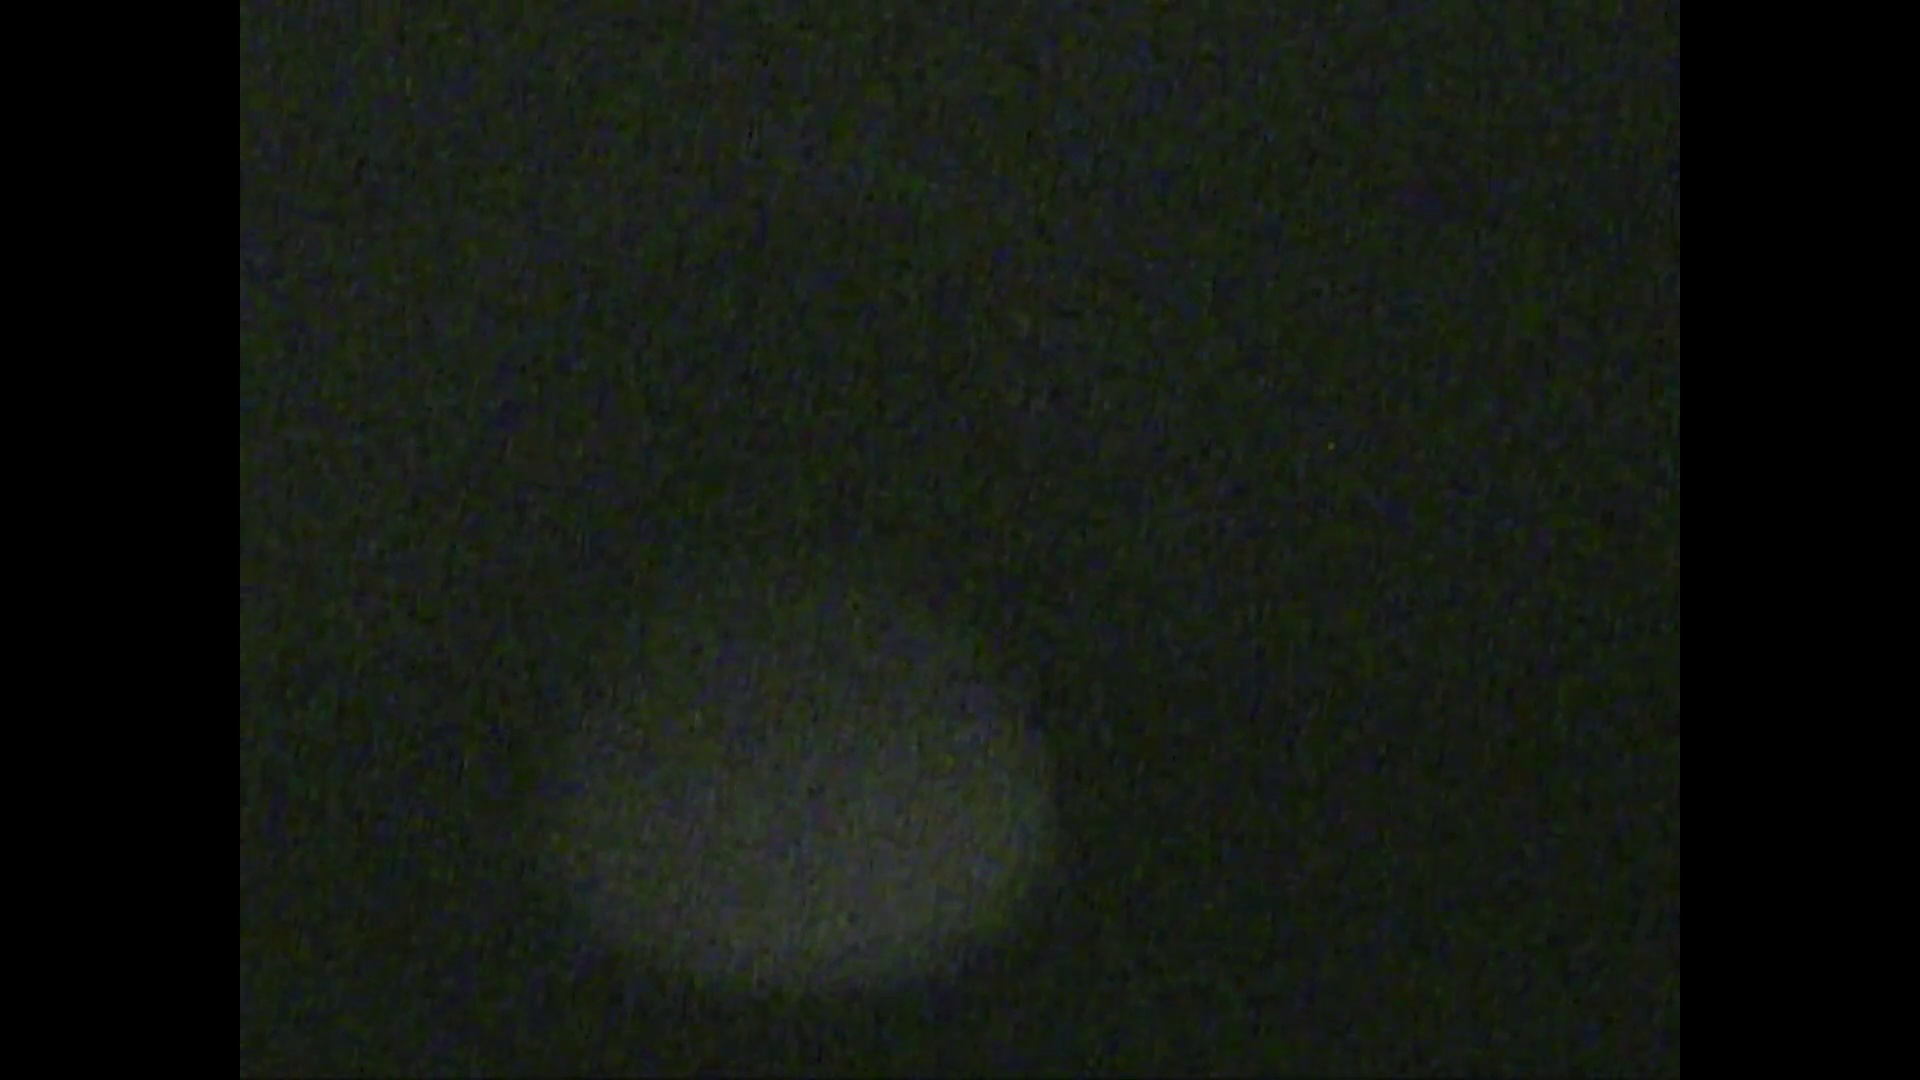

Saving figure Class_Laser-off_sample_24_index_13289


/home/lequn/anaconda3/envs/torch/lib/python3.8/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1764
  warnings.warn(
/tmp/ipykernel_3524/735062414.py:61: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  S_dB = librosa.power_to_db(spec, ref=np.max)
/home/lequn/anaconda3/envs/torch/lib/python3.8/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


<Figure size 640x480 with 0 Axes>

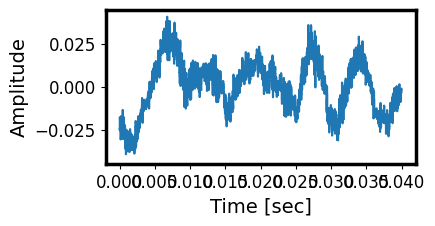

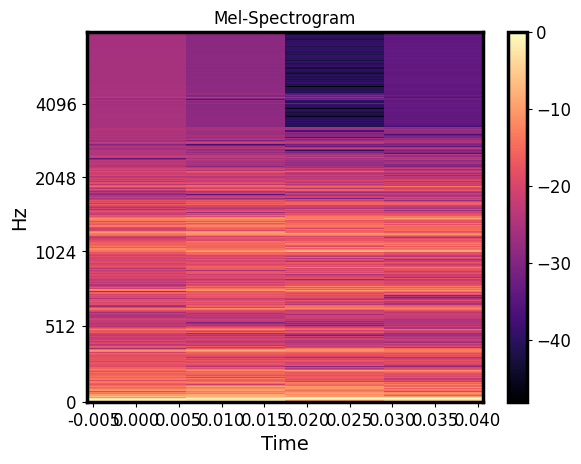

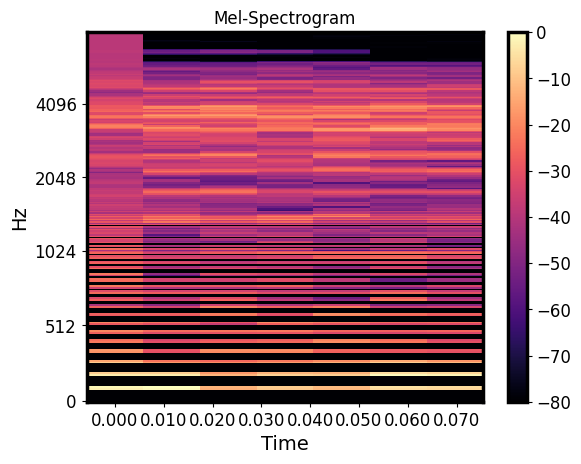

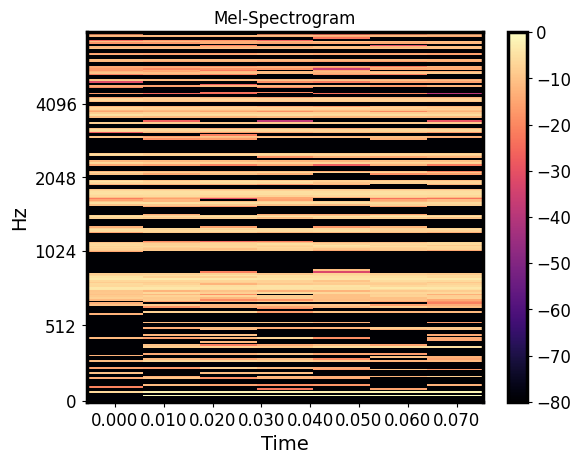

In [23]:
import IPython

n_fft = 512
win_length = None
hop_length = 256
n_mels = 256
n_mfcc = 256


def display_random_image_audio_pair(annotations, data_folder_path):
    # Randomly select a row
    selected_row = annotations.sample().iloc[0]
    
    # Get file names and class
    index = selected_row['sample index']
    sample_number = str(selected_row['Sample number'])
    audio_file_name = selected_row['audio_file_name']
    image_file_name = selected_row['image_file_name']
    class_name = selected_row['class_name_v2']
    
    # Construct full file paths
    audio_path = os.path.join(data_folder_path, sample_number, 'raw_audio', audio_file_name)
    image_path = os.path.join(data_folder_path, sample_number,  'images', image_file_name)
    
    # Load the audio file
    sound, sr = librosa.load(audio_path, sr=None)
    
    # Display the image
    print(f"Class: {class_name}")
    IPython.display.display(IPython.display.Image(image_path, width=100))
    save_fig(f'Class_{class_name}_sample_{sample_number}_index_{index}')
    
    # Play the audio
    IPython.display.display(IPython.display.Audio(filename=audio_path))
    
    # Visualize the waveform
    simple_visualization(sound, sr=sr, fig_size=(4, 2))
    
    # Visualize the spectrogram
    spec = librosa.stft(sound)
    # plot_spectrogram(spec, sr=sr)
    plot_spectrogram(spec, sr)
    
    # Visualize the mel-spectrogram
    # melspec_librosa = librosa.feature.melspectrogram(sound,sr=44100, n_fft=512, hop_length=256,win_length=None,
    #                                                  center=True,pad_mode="reflect", power=2.0, n_mels=256,
    #                                                  norm='slaney', htk=True)

    melspec = librosa.feature.melspectrogram(y=sound, sr=44100, n_fft=n_fft,
                                              win_length=win_length, hop_length=hop_length,
                                              n_mels=n_mels, htk=True, norm=None)
    mfcc_librosa = librosa.feature.mfcc(S=librosa.core.spectrum.power_to_db(melspec),
                                        n_mfcc=n_mfcc, dct_type=2, norm='ortho')
    
    plot_spectrogram(melspec, sr)
    plot_spectrogram(mfcc_librosa, sr)



# Call the function with annotations and the path to your data
display_random_image_audio_pair(df_multimodal, Dataset_path)

In [38]:
# exp_21_raw = exp_21_raw[int(44100*17):int(44100*221.3)] 
# exp_21_equalized = exp_21_equalized[int(44100*17):int(44100*221.3)]
# exp_21_bandpassed = exp_21_bandpassed[int(44100*17):int(44100*221.3)]
# exp_21_denoised = exp_21_denoised[int(44100*17):int(44100*221.3)]


exp_22_raw = exp_22_raw[int(44100*18.15):int(44100*205.55)] #190.6 seconds, Previously (19-204.19). A total of 5614 melt pool images - 187.4 seconds
exp_22_equalized = exp_22_equalized[int(44100*18.15):int(44100*205.55)]
exp_22_bandpassed = exp_22_bandpassed[int(44100*18.15):int(44100*205.55)] #(180.3 - 205.7)
exp_22_denoised = exp_22_denoised[int(44100*18.15):int(44100*205.55)]


# exp_23_raw = exp_23_raw[int(44100*22.7):int(44100*475.2)] #475
# exp_23_equalized = exp_23_equalized[int(44100*22.7):int(44100*475.2)]
# exp_23_bandpassed = exp_23_bandpassed[int(44100*22.7):int(44100*475.2)]
# exp_23_denoised = exp_23_denoised[int(44100*22.7):int(44100*475.2)]


# exp_24_raw = exp_24_raw[int(44100*23):int(44100*865.3)] 
# exp_24_equalized = exp_24_equalized[int(44100*23):int(44100*865.3)]
# exp_24_bandpassed = exp_24_bandpassed[int(44100*23):int(44100*865.3)]
# exp_24_denoised = exp_24_denoised[int(44100*23):int(44100*865.3)]


# exp_25_raw = exp_25_raw[44100*19:]
# exp_25_equalized = exp_25_equalized[44100*19:]
# exp_25_bandpassed = exp_25_bandpassed[44100*19:]
# exp_25_denoised = exp_25_denoised[44100*19:]


# exp_26_raw = exp_26_raw[int(44100*10.8):int(44100*446.6)] #446
# exp_26_equalized = exp_26_equalized[int(44100*10.8):int(44100*446.6)]
# exp_26_bandpassed = exp_26_bandpassed[int(44100*10.8):int(44100*446.6)]
# exp_26_denoised = exp_26_denoised[int(44100*10.8):int(44100*446.6)]

## Random check

In [39]:
ipd.Audio(exp_22_denoised[int(44100*183.5):int(44100*186.4)], rate=sr)

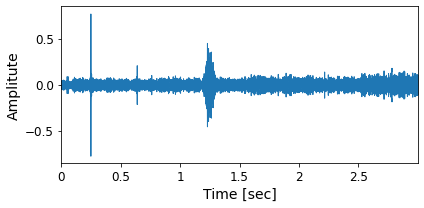

In [40]:
simple_visualization(exp_22_denoised[int(44100*9):int(44100*12)])
# # save_fig("25_simple_vis")

In [41]:
len(exp_22_denoised)/44100

187.40002267573695

## Segment the acoustic signal according to images

In [42]:
# Total length of sample 22 should be 187.4 seconds, images - 5615 ==> each segments 0.03338 seconds
# 187.4*44100 = 8,264,340; 8,264,340/5614 = 1,472

def segment_signal(signal, num_of_meltpool_pictures):
    num_samples_per_seg = int(len(signal)/num_of_meltpool_pictures)
    print (num_samples_per_seg)
    
    signal_seg = [] # list containing all small segments
    for i in range(num_of_meltpool_pictures):
        signal_seg.append(signal[(num_samples_per_seg*i):(num_samples_per_seg*(i+1))])
    print(len(signal_seg))
    return signal_seg
    
    
exp_22_raw_seg = segment_signal(exp_22_denoised, 5615) # 1602 for 10 Hz, 5614 for 30 Hz
exp_22_equalized_seg = segment_signal(exp_22_denoised, 5615)
exp_22_bandpassed_seg = segment_signal(exp_22_denoised, 5615)
exp_22_denoised_seg = segment_signal(exp_22_denoised, 5615)

1471
5615
1471
5615
1471
5615
1471
5615


### Inspections: selected examples

#### (1) crack location: image frame 306, 307, 308

In [55]:
test = []
list301 = list(exp_22_denoised_seg[301])
list302 = list(exp_22_denoised_seg[302])
list303 = list(exp_22_denoised_seg[303])
list304 = list(exp_22_denoised_seg[304])
list305 = list(exp_22_denoised_seg[305])
list306 = list(exp_22_denoised_seg[306])
list307 = list(exp_22_denoised_seg[307])
list308 = list(exp_22_denoised_seg[308])
list309 = list(exp_22_denoised_seg[309])
# test.extend(list301)
# test.extend(list302)
# test.extend(list303)
# test.extend(list304)
# test.extend(list305)
test.extend(list306)
test.extend(list307)
test.extend(list308)
test.extend(list309)

In [56]:
type(test)

list

In [57]:
test = np.asarray(test)

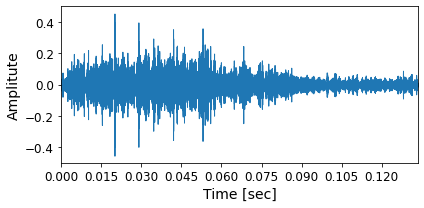

In [58]:
simple_visualization(test)

In [59]:
ipd.Audio(test, rate=sr)

#### (2) Laser-on: image frame 31 - 39; 34, 35, 36 are laser start

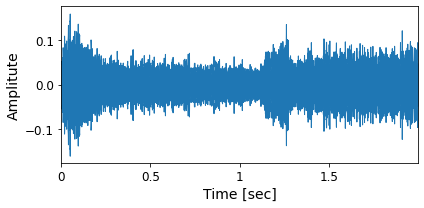

In [60]:
simple_visualization(exp_22_denoised[int(44100*0):int(44100*2)])

In [61]:
ipd.Audio(exp_22_denoised[int(44100*0):int(44100*2)], rate=sr)

In [65]:
test = []
list27 = list(exp_22_denoised_seg[27])
list28 = list(exp_22_denoised_seg[28])
list29 = list(exp_22_denoised_seg[29])
list30 = list(exp_22_denoised_seg[30])
list31 = list(exp_22_denoised_seg[31])
list32 = list(exp_22_denoised_seg[32])
list33 = list(exp_22_denoised_seg[33])
list34 = list(exp_22_denoised_seg[34])
list35 = list(exp_22_denoised_seg[35])
list36 = list(exp_22_denoised_seg[36])
list37 = list(exp_22_denoised_seg[37])
list38 = list(exp_22_denoised_seg[38])
# test.extend(list27)
# test.extend(list28)
# test.extend(list29)
# test.extend(list30)
# test.extend(list31)
# test.extend(list32)
test.extend(list33)
test.extend(list34)
test.extend(list35)
test.extend(list36)
test.extend(list37)
test.extend(list38)
test = np.asarray(test)

In [66]:
ipd.Audio(test, rate=sr)

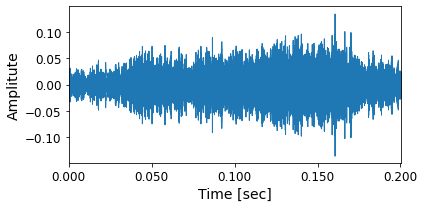

In [67]:
simple_visualization(test)

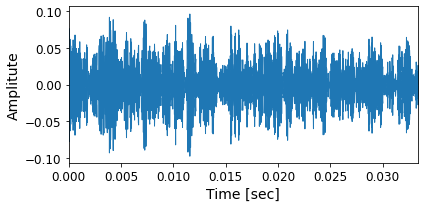

In [196]:
simple_visualization(exp_22_equalized_seg[168])

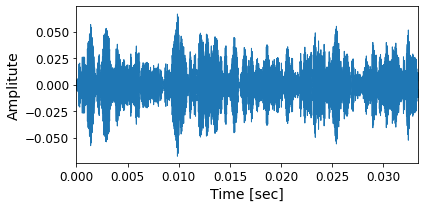

In [197]:
simple_visualization(exp_22_bandpassed_seg[10])

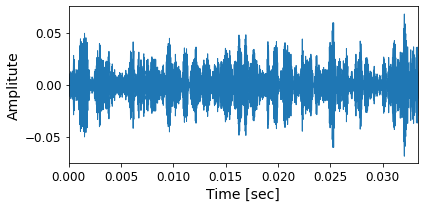

In [198]:
simple_visualization(exp_22_denoised_seg[12])